In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torchmetrics.regression import R2Score 
from torchmetrics.functional.regression import r2_score
from torchinfo import summary 

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

In [2]:
torch.manual_seed(1) # 시드 설정

Device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE => {Device}') # cuda가 있으면 GPU 사용, 없으면 CPU 사용

DEVICE => cpu


In [3]:
DATA_FILE = '../../../Data/boston.csv'

bostonDF = pd.read_csv(DATA_FILE)
bostonDF.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.9,9.14,21.6


In [4]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [5]:
bostonDF.isna().sum() # 결측치 없음

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

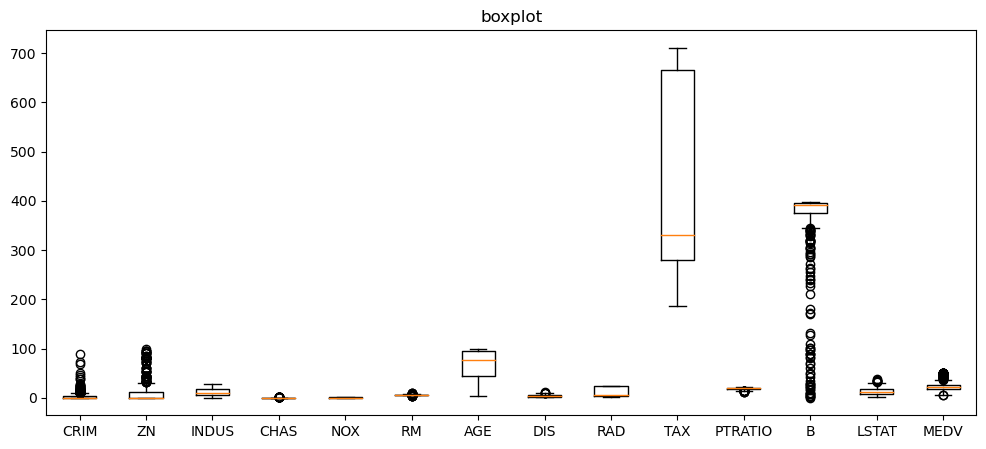

In [6]:
plt.figure(figsize = (12, 5))
plt.boxplot(bostonDF)
plt.xticks(range(1, len(bostonDF.columns)+1), bostonDF.columns)
plt.title('boxplot')
plt.show()

In [7]:
Q1 = bostonDF.quantile(0.25)
Q3 = bostonDF.quantile(0.75)
IQR = Q3 - Q1

In [8]:
# 이상치 모두 제거하는 경우
outliers = (bostonDF < (Q1 - 1.5*IQR)) | (bostonDF > (Q3 + 1.5*IQR))
outliers

idx = (outliers.sum(axis = 1) == 0).tolist() # 이상치가 없어야 0이 나올것이기 때문

bostonDF = bostonDF.iloc[idx,:]
bostonDF

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [9]:
model = nn.Sequential(nn.Linear(len(bostonDF.columns)-1, 10),
                      nn.ReLU(),
                      nn.Linear(10, 5),
                      nn.ReLU(),
                      nn.Linear(5, 1))

In [10]:
print(model) # 모델 구조
summary(model, input_size = (len(bostonDF), len(bostonDF.columns)-1))

Sequential(
  (0): Linear(in_features=13, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [268, 1]                  --
├─Linear: 1-1                            [268, 10]                 140
├─ReLU: 1-2                              [268, 10]                 --
├─Linear: 1-3                            [268, 5]                  55
├─ReLU: 1-4                              [268, 5]                  --
├─Linear: 1-5                            [268, 1]                  6
Total params: 201
Trainable params: 201
Non-trainable params: 0
Total mult-adds (M): 0.05
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.05

In [11]:
for name, param in model.named_parameters():
    print(f'[{name}] {param}\n')

[0.weight] Parameter containing:
tensor([[ 0.1429, -0.1224, -0.0538,  0.1302, -0.2611,  0.1663, -0.0571,  0.1411,
          0.0386, -0.0340,  0.0769,  0.0137,  0.1013],
        [-0.1081, -0.0202, -0.0250,  0.0402, -0.0011,  0.2425,  0.0863, -0.1033,
         -0.1675, -0.0465, -0.1196, -0.0889,  0.0133],
        [ 0.1653,  0.1507, -0.2711,  0.1719,  0.0775,  0.2631,  0.1831, -0.2527,
         -0.2637, -0.1338,  0.2435, -0.0462,  0.1187],
        [-0.1289,  0.2721, -0.1173,  0.2080,  0.0033, -0.1461,  0.1426, -0.1472,
          0.0816, -0.0801, -0.0304, -0.2666, -0.1322],
        [ 0.1505, -0.0674,  0.2763,  0.2223, -0.0130, -0.1851,  0.1689,  0.0861,
         -0.1793,  0.1802,  0.1684,  0.2460, -0.1555],
        [-0.0457, -0.0054,  0.0405, -0.2105, -0.1968,  0.1509, -0.0650,  0.1355,
          0.0158,  0.0911,  0.0610,  0.1008,  0.1375],
        [-0.2569,  0.1396, -0.1950, -0.2093,  0.0169, -0.0473,  0.1629, -0.1606,
         -0.2466,  0.2018, -0.0411,  0.1560,  0.0892],
        [-0.208

In [12]:
adam_optim = optim.Adam(model.parameters(), lr = 0.001)

In [13]:
# 피쳐, 타겟 분리
featureDF = bostonDF[bostonDF.columns[:-1]]
targetDF = bostonDF[['MEDV']]

print(featureDF.shape, targetDF.shape)

(268, 13) (268, 1)


In [14]:
# 훈련, 검증, 테스트 분리
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, train_size=0.8, random_state=5)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=5)

print(f"[feature] Train : {X_train.shape}, Valid : {X_val.shape}, Test : {X_test.shape}")
print(f"[target] Train : {y_train.shape}, Valid : {y_val.shape}, Test : {y_test.shape}")

[feature] Train : (171, 13), Valid : (43, 13), Test : (54, 13)
[target] Train : (171, 1), Valid : (43, 1), Test : (54, 1)


In [15]:
# 피쳐 스케일링
ss = StandardScaler()
ss.fit(X_train)

StandardScaler()

In [16]:
X_train_scaled = pd.DataFrame(ss.transform(X_train), columns=bostonDF.columns[:-1])
X_val_scaled = pd.DataFrame(ss.transform(X_val), columns=bostonDF.columns[:-1])

In [17]:
EPOCH = 500
BATCH_SIZE = 12
BATCH_CNT = X_train_scaled.shape[0]//BATCH_SIZE

print(f"EPOCH : {EPOCH}, BATCH_SIZE : {BATCH_SIZE}, BATCH_CNT : {BATCH_CNT}")

EPOCH : 500, BATCH_SIZE : 12, BATCH_CNT : 14


In [18]:
def testing(testDF, targetDF, kind = 'Val'): # 입력은 데이터 프레임으로
    # Tensor화 (텐서로 만들어야 loss를 계산할 수 있음)
    testTS = torch.FloatTensor(testDF.values).to(Device) 
    targetTS = torch.FloatTensor(targetDF.values).to(Device)
    # testDF는 데이터프레임이니까 values를 통해 array로 만듦
    # to(Device)는 텐서를 CPU나 GPU (가속 장치)로 옮길 수 있음

    with torch.no_grad(): # 일시적으로 그레디언트 계산을 비활성화
        # (1) 학습 (forward)
        pred_y = model(testTS) # 모델에 텐서를 전달하면 예측값 반환
        # print(f'예측값 : {pred_y}, {pred_y.shape}')

        # (2) 손실 함수 계산
        loss = F.mse_loss(pred_y, targetTS)

        # (3) 성능 평가 (r2)
        r2 = r2_score(pred_y, targetTS)

        # (4) 학습 결과 출력
        # print(f"[{kind}] Loss : {loss}, R2 : {r2}")

    return loss, r2

In [19]:
def training(X_trainDF, y_trainDF, X_testDF, y_testDF): # 입력은 데이터 프레임으로
    train_loss_list = []
    val_loss_list = []
    train_r2_list = []
    val_r2_list = []

    for epoch in range(1, EPOCH+1):
        loss_list = [] # 배치 카운트 마다 저장될 loss 리스트
        r2_list = [] # 배치 카운트 마다 저장될 r2 리스트

        for i in range(BATCH_CNT):
            start = i*BATCH_SIZE
            end = start+BATCH_SIZE
            # 배치 사이즈 만큼 건너뛰어 인덱싱

            # 배치 사이즈 만큼 꺼내서 Tensor화
            BSX_train = torch.FloatTensor(X_trainDF[start:end].values).to(Device) # values로 array화
            BSy_train = torch.FloatTensor(y_trainDF[start:end].values).to(Device) # values로 array화
            # print(f"X_train : {BSX_train.shape}, {BSX_train.device}, {BSX_train.dtype}")
            # print(f"y_train : {BSy_train.shape}, {BSy_train.device}, {BSy_train.dtype}")

            # (1) 학습 (forward)
            pred_BSy = model(BSX_train) # 배치 사이즈 만큼 꺼낸걸 학습

            # (2) 손실 함수 계산
            BS_loss = F.mse_loss(pred_BSy, BSy_train) # 배치 사이즈에서의 손실값
            BS_r2 = r2_score(pred_BSy, BSy_train)
            loss_list.append(BS_loss.item()) # 배치 손실값 리스트에 저장 (나중에 평균값 계산)
            r2_list.append(BS_r2.item()) # 배치 r2 리스트에 저장 (나중에 평균값 계산)

            # (3) 최적화 - 가중치, 절편 업데이트 (backward)
            adam_optim.zero_grad() # 기울기 초기화
            BS_loss.backward() # 역전파 (기울기 계산)
            adam_optim.step() # 가중치, 절편 업데이트

        # (4) 검증 (검증은 그냥 전체 사이즈 한번에 넣는듯?)
        val_loss, val_r2 = testing(X_testDF, y_testDF)
        val_loss_list.append(val_loss.item())
        val_r2_list.append(val_r2.item())
        # 에포크 마다 계산된 loss와 r2 저장

        # 훈련 세트 성능지표 저장
        train_loss_list.append(sum(loss_list)/len(loss_list)) # loss 평균값
        train_r2_list.append(sum(r2_list)/len(r2_list)) # r2 평균값

        # 에포크 10단위마다 학습 결과 출력
        if epoch % 10 == 0:
            print(f"[{epoch}/{EPOCH}] Train Loss : {train_loss_list[-1]}, Train R2 : {train_r2_list[-1]}")
            print(f"        Valid Loss : {val_loss_list[-1]}, Valid R2 : {val_r2_list[-1]}")

    return train_loss_list, val_loss_list, train_r2_list, val_r2_list

In [20]:
# 모델 학습
train_loss, val_loss, train_r2, val_r2 = training(X_train_scaled, y_train, X_val_scaled, y_val)

[10/500] Train Loss : 392.67745317731584, Train R2 : -23.13387966156006
        Valid Loss : 385.0783996582031, Valid R2 : -11.86801528930664
[20/500] Train Loss : 155.26898738316126, Train R2 : -8.920560802732195
        Valid Loss : 147.69549560546875, Valid R2 : -3.935482978820801
[30/500] Train Loss : 47.148515701293945, Train R2 : -1.9977743540491377
        Valid Loss : 41.11360549926758, Valid R2 : -0.3738774061203003
[40/500] Train Loss : 26.119706221989222, Train R2 : -0.6284084575516837
        Valid Loss : 27.071516036987305, Valid R2 : 0.09536164999008179
[50/500] Train Loss : 21.188678673335485, Train R2 : -0.3219405710697174
        Valid Loss : 24.756250381469727, Valid R2 : 0.1727299690246582
[60/500] Train Loss : 17.968606199537003, Train R2 : -0.118773238999503
        Valid Loss : 22.240671157836914, Valid R2 : 0.2567921280860901
[70/500] Train Loss : 15.44407480103629, Train R2 : 0.04269640360559736
        Valid Loss : 19.824308395385742, Valid R2 : 0.3375387787818

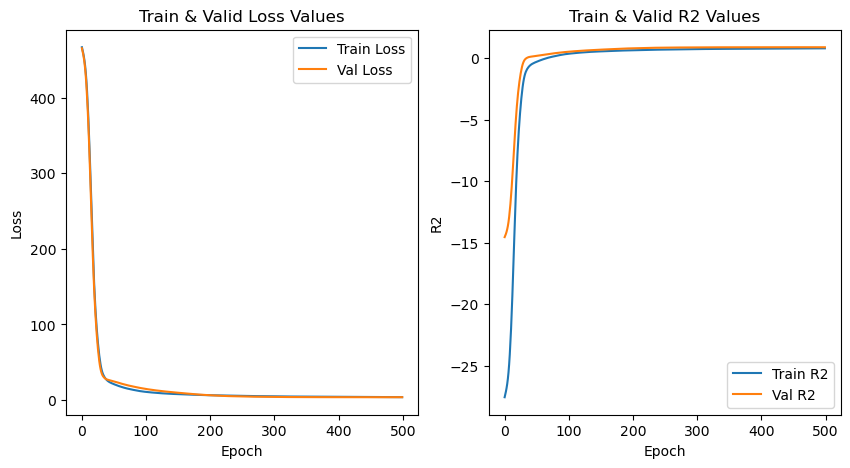

In [21]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

train_list = [train_loss, train_r2]
val_list = [val_loss, val_r2]
label_list = ['Loss', 'R2']

for i in range(2):
    axs[i].plot(train_list[i], label = f'Train {label_list[i]}')
    axs[i].plot(val_list[i], label = f'Val {label_list[i]}')
    axs[i].set_title(f'Train & Valid {label_list[i]} Values')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel(label_list[i])
    axs[i].legend()
plt.show()